In [ ]:
# PART 1

In [133]:
# importing our required packages for this product
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set theurl and endpoint we want to hit
url = 'https://api.yelp.com/v3/businesses/search'
url2 = 'https://api.yelp.com/v3/businesses/{id}/reviews'

In [4]:
# created a separate folder for keys to make our data_set cleaner
from  keys  import  client_id, api_key

In [6]:
headers = {
        'Authorization': 'Bearer {}'.format(api_key),
    }

In [140]:
# defining our variables to search through businesses within yelp using keyword, location, categories, and radius from location
term = 'restaurant'
location = 'Los Angeles'
categories = 'cafe'
radius = 3500

In [135]:
# setting up our parameters for our search on yelp
url_params = {
                "term": term.replace(' ', '+'),
                "location": location.replace(' ', '+'),
                "categories" : categories,
                "radius": radius,
                "limit": 50,
            }

In [136]:
# grabbing our data
response = requests.get(url, headers=headers, params=url_params)

In [137]:
# checking to make sure our data was received correctly
response.status_code

200

In [138]:
# putting data into a format we can understand using .json
data = response.json()
# check to see how our data looks
data['businesses'][10]

{'id': 'SLxKy00itrk-ta8r8zCzTA',
 'alias': 'easy-street-burgers-los-angeles',
 'name': 'Easy Street Burgers',
 'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/L7F0GSi_uN8txW-8AEDSCQ/o.jpg',
 'is_closed': False,
 'url': 'https://www.yelp.com/biz/easy-street-burgers-los-angeles?adjust_creative=z5FPRiFN1Th8uQRPbWSEIg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=z5FPRiFN1Th8uQRPbWSEIg',
 'review_count': 121,
 'categories': [{'alias': 'burgers', 'title': 'Burgers'}],
 'rating': 4.5,
 'coordinates': {'latitude': 34.088796, 'longitude': -118.308573},
 'transactions': ['delivery', 'pickup'],
 'price': '$',
 'location': {'address1': '1000 N Western Ave',
  'address2': '',
  'address3': None,
  'city': 'Los Angeles',
  'zip_code': '90029',
  'country': 'US',
  'state': 'CA',
  'display_address': ['1000 N Western Ave', 'Los Angeles, CA 90029']},
 'phone': '+18189663009',
 'display_phone': '(818) 966-3009',
 'distance': 3247.065962603458}

In [29]:
# PART 2

In [30]:
# import sqlite3 so we can begin to create our tables
import sqlite3

In [31]:
# must created a connection between our code and sqlite3, naming our database yelp
conn = sqlite3.connect('yelp.db')
cursor = conn.cursor()

In [ ]:
# create our business table
cursor.execute("""Create TABLE businesses(
                                businessid TEXT,
                                rating NUMERIC,
                                price TEXT,
                                name TEXT,
                                review_count INTEGER,
                                address TEXT,
                                city TEXT,
                                metro_area TEXT,
                                zip_code TEXT
                                )
                """)
conn.commit()

In [17]:
# create our review table
cursor.execute("""Create TABLE reviews(
                                businessid TEXT,
                                reviewID INTEGER,
                                rating NUMERIC,
                                time_created TEXT,
                                text TEXT
                                )
                """)
conn.commit()

In [33]:
# first function calling on url, url_params and api_key that we defined above.
def yelp_call(url, url_params, api_key):
    response = requests.get(url, headers=headers, params=url_params)
    data = response.json()
    return data

In [34]:
# creating a variable that returns our yelp_call
results = yelp_call(url, url_params, api_key)

In [35]:
# creating a function to parse our business results into our different categories and looping over each dictionary 
# to retrieve the items we are looking for within business within our yelp data set
def parse_results(results):
    
    parsed_results = []
    count = 0
    
    for business in results['businesses']:
        for item in ['businessid', 'rating', 'price', 'name', 'review_count', 'address', 'city', 'metro_area', 'zip_code']:
            if item not in business:
                business[item] = np.nan
            else:
                business[item]
    
        biz_tuple = (business['id'],
                business['rating'],
                business['price'],
                business['name'],
                business['review_count'],
                business['location']['display_address'][0],
                business['location']['city'],
                location,
                business['location']['zip_code']
                    )
        count += 1
        parsed_results.append(biz_tuple)
    
    return parsed_results

In [36]:
# inserting our information into our business reviews table
def db_insert(conn, cursor, parse_results):
    add_business = ("""
    INSERT INTO businesses (businessid, rating, price, name, review_count, address, city, metro_area, zip_code) 
    VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)
    """)
    cursor.executemany(add_business, parse_results)
    conn.commit()

In [37]:
# create a variable  to keep track of which result you are in. 
cur = 0

#set up a while loop to go through and grab the result 
while cur < 1000:
    #set the offset parameter to be where you currently are in the results 
    url_params['offset'] = cur
    #make your API call with the new offset number
    results = yelp_call(url, url_params, api_key)
    
    #after you get your results you can now use your function to parse those results
    parsed_results = parse_results(results)
    
    # use your function to insert your parsed results into the db
    db_insert(conn, cursor, parsed_results)
    #increment the counter by 50 to move on to the next results
    cur += 50
    
print(cur)

1000


In [318]:
# creating a list of strictly business_ID's so that we can use those to grab our reviews
query = ("SELECT businessid FROM businesses")
cursor.execute(query)
business_ID_list = cursor.fetchall()

[('6i7KnRylm4bhPIApDFSVCg',),
 ('h1R2iKYdm2lwukzMJvJqDw',),
 ('rr-hXB0ZqXLzUP97yftp0g',),
 ('AIhWsp8yNfKZfaX9d9Yajg',),
 ('qAAoilHU25Qr45FOQlA19g',),
 ('JYGPEUZy4k5ObXGIjcD3DA',),
 ('IzRINfSLBr6k_dq1e2WNew',),
 ('HuQtriV_ApipXfM8xax33w',),
 ('DrToq9357afdpOyO5w0Y5w',),
 ('MlmcOkwaNnxl3Zuk6HsPCQ',),
 ('qCrSlf_TSVxITOYIBXGdJQ',),
 ('TsVu9GJQwuFBZVP_sg2k7A',),
 ('q8buTNBt3FU9vie0D5OOxA',),
 ('jisjJNoV5jzfAMIYKn7y5A',),
 ('vs8USEc1A480H8MnmFKs5A',),
 ('DoyIC0ElqglrlHBKDxXOwg',),
 ('-3S1PdyDbSQcqkIaX8VKrQ',),
 ('BEItepse0gBSfkJ4sb_k-g',),
 ('IxuAHGu-eQ4fZJZTdzGTYQ',),
 ('YCEgBqClpWXQ3leoAhWjoA',),
 ('TWHGJkTAbF22hvXeReQp9w',),
 ('Fb3WueRF1ekhs72psinq5w',),
 ('0SerWqGwzNWpTA2RBLVdUg',),
 ('-ZcCFCdqMwOPXItB3REecA',),
 ('KtEMG1Aln3vQzte92QJxlw',),
 ('YoQn8MtOimQbqi839TmeZw',),
 ('y4X0KfHJ5XWwxMIRukVr1Q',),
 ('1ZEUvoDlg7ixlwwlK2a3mQ',),
 ('LLj451UZrvt3SkZVrEZ4ew',),
 ('HTFByVH44biQsc_R8sEOjg',),
 ('23Qrcz2i9e2e8MstUIIO0A',),
 ('h_VkRMpSrtjdKDxUJ7sDOQ',),
 ('H9ZlIqEp930ZRniH6VRp8w',),
 ('frRPjJ0

In [54]:
# Because our list above is a tuple and we only want our businessid, we loop over the tuple and grab the first element which is the businessid 
# in order to striclty have a list of businessID - this will be used to grab our reviews!
biz_id_list = []
for biz in business_ID_list:
    biz_id = biz[0]
    biz_id_list.append(biz_id)

In [59]:
# very similar to the above yelp_call, but now only using one paramater (ID) and changing our URL so that we can retrieve information regarding the reviews
def yelp_call_reviews(ID):
    url = 'https://api.yelp.com/v3/businesses/{}/reviews'.format(ID)
    response = requests.get(url, headers=headers)
    data = response.json()
    return data

In [61]:
# checked to see what data looks like
biz = biz_id_list[0]

In [68]:
# creating a function to parse our results into our different categories and looping over each dictionary to retrieve the items we are looking for within our yelp data set
def parse_review(businessID, review_results):
    tuple_lists = [] 
    
    if 'error' in review_results:
        if review_results['error']['code'] == 'BUSINESS_UNAVAILABLE':
            return None
    else:
        for review in review_results['reviews']:
            for item in ['text','rating','time_created']:
                if item not in review:
                    review[item] = np.nan
            review_tuple = (businessID,
                            review['id'], 
                            review['rating'],
                            review['time_created'],
                            review['text'],
                          )
            tuple_lists.append(review_tuple)
        
    return tuple_lists

In [70]:
# inseerting information we parsed into our reviews table
def review_insert(conn, cursor, parse_reviews):
    add_reviews = ("""
    INSERT INTO reviews(businessid, reviewID, rating, time_created, text) 
    VALUES(?, ?, ?, ?, ?)
    """)
    cursor.executemany(add_reviews, parse_reviews)
    conn.commit()

In [319]:
# biz_id_list.index('ACA2q2bYEy8eDzvoad9SZQ')
# this code is good to use if your for loop is not iterating over each sequence. 

In [74]:
# using a for loop to iterate over 3 reviews for each business and using our functions to put into database
for biz in biz_id_list:
    review_results = yelp_call_reviews(biz)
    if review_results == None:
        pass
    parsed_reviews = parse_review(biz, review_results)
    review_insert(conn, cursor, parsed_reviews)
    

In [ ]:
# SQL QUESTIONS

In [75]:
# Which are the 5 most reviewed businesses?
cursor.execute("""
SELECT name, review_count
FROM businesses
ORDER BY review_count DESC
LIMIT 5
""").fetchall()

[("Brenda's French Soul Food", 11055),
 ('Tartine Bakery & Cafe', 8014),
 ("Pink's Hot Dogs", 7163),
 ('Burma Superstar', 6837),
 ('Republique', 5628)]

In [ ]:
# What is the highest rating recieved in your data set and how many businesses have that rating?
cursor.execute("""
SELECT rating, count(*)
FROM businesses
GROUP BY rating
ORDER BY rating DESC
LIMIT 1""").fetchall()

In [ ]:
# What percentage of businesses have a rating greater than or 4.5?
cursor.execute("""SELECT round(count(rating), 2) * 100 / 
(SELECT count(businessid) FROM businesses)
FROM BUSINESSES
WHERE rating >= 4.5""").fetchall()

In [ ]:
# What percentage of businesses have a rating less than 3?
cursor.execute("""SELECT round(count(rating), 2) * 100 / 
(SELECT count(businessid) FROM businesses)
FROM BUSINESSES
WHERE rating < 3""").fetchall()

In [ ]:
# What is the average rating of businesses that have a price label of one dollar sign? Two dollar signs? Three dollar signs?
cursor.execute("""SELECT
                   price, AVG(rating)
                   FROM businesses
                   --WHERE  price = '$' OR price = '$$' OR price = '$$$'
                   GROUP BY price
                   """).fetchall()

In [ ]:
# Return the text of the reviews for the most reviewed business.
cursor.execute("""SELECT text
                FROM reviews
                WHERE businessid = (SELECT businessid 
                FROM businesses 
                ORDER BY review_count DESC
                LIMIT 1)""").fetchall()

In [ ]:
# Return the name of the business with the most recent review.
cursor.execute("""SELECT name
                FROM businesses
                WHERE businessid = (SELECT businessid 
                FROM reviews 
                ORDER BY time_created DESC
                LIMIT 1)""").fetchall()

In [ ]:
# Find the highest rated business and return text of the most recent review. If multiple business have the same rating, 
# select the business with the most reviews.
cursor.execute("""SELECT b.name, r.text, b.rating, r.time_created, b.review_count
                FROM reviews AS r
                LEFT JOIN businesses AS b 
                ON b.businessid = r.businessid
                ORDER BY b.rating DESC, b.review_count DESC, r.time_created DESC
                LIMIT 1""").fetchall()

In [85]:
# Find the lowest rated business and return text of the most recent review. If multiple business have the same rating, 
# select the business with the least review
cursor.execute("""SELECT b.name, r.text, b.rating, r.time_created, b.review_count
                FROM reviews AS r
                LEFT JOIN businesses AS b 
                ON b.businessid = r.businessid
                ORDER BY b.rating, b.review_count, r.time_created DESC
                LIMIT 1""").fetchall()

[('615 Food Court',
  "DO NOT EVER ORDER FOOD FROM HERE! If you're working for a delivery company, AVOID accepting orders from this location. \n\nIt's ALWAYS busy, orders ALWAYS...",
  1.5,
  '2020-12-14 23:14:44',
  15)]

In [86]:
# bringing our business table down from SQL
cursor.execute("""SELECT * 
                FROM businesses
                """) 
# putting our data into a pandas database
df = pd.DataFrame(cursor.fetchall())
df.columns = [x[0] for x in cursor.description]
df

,businessid,rating,price,name,review_count,address,city,metro_area,zip_code
0,6i7KnRylm4bhPIApDFSVCg,4.5,$$,Dave's Hot Chicken,3380,970 N Western Ave,Los Angeles,Los Angeles,90029
1,h1R2iKYdm2lwukzMJvJqDw,4.5,$$,Hangari Kalguksu,1720,3470 W 6th St,Los Angeles,Los Angeles,90020
2,rr-hXB0ZqXLzUP97yftp0g,4.0,$$,Osteria Mamma,1651,5732 Melrose Ave,Los Angeles,Los Angeles,90038
3,AIhWsp8yNfKZfaX9d9Yajg,4.5,$$,Pasta Sisters,1560,3343 W Pico Blvd,Los Angeles,Los Angeles,90019
4,qAAoilHU25Qr45FOQlA19g,4.5,$$,Kang Ho-dong Baekjeong,4326,3465 W 6th St,Los Angeles,Los Angeles,90020
...,...,...,...,...,...,...,...,...,...
1995,_sl4NUAHcrqU-F9x25kBQw,3.5,$$,Academy Bar & Kitchen,140,1800 Fillmore St,San Francisco,San Francisco,94115
1996,87WcL6ICku5piRxlwtcYOw,3.5,$$,Ike's Love & Sandwiches,251,901 Polk St,San Francisco,San Francisco,94109
1997,pzTBJAR0dr3xQ4tjF7ageg,4.0,$$,Old Jerusalem Restaurant,1073,2966 Mission St,San Francisco,San Francisco,94110
1998,Rd-tfZAKetgGjVDGylcKow,4.0,None,Los Poblanos,6,13TH St,San Francisco,San Francisco,94103


In [87]:
# showing the first five elements within our data fram
df.head()

,businessid,rating,price,name,review_count,address,city,metro_area,zip_code
0,6i7KnRylm4bhPIApDFSVCg,4.5,$$,Dave's Hot Chicken,3380,970 N Western Ave,Los Angeles,Los Angeles,90029
1,h1R2iKYdm2lwukzMJvJqDw,4.5,$$,Hangari Kalguksu,1720,3470 W 6th St,Los Angeles,Los Angeles,90020
2,rr-hXB0ZqXLzUP97yftp0g,4.0,$$,Osteria Mamma,1651,5732 Melrose Ave,Los Angeles,Los Angeles,90038
3,AIhWsp8yNfKZfaX9d9Yajg,4.5,$$,Pasta Sisters,1560,3343 W Pico Blvd,Los Angeles,Los Angeles,90019
4,qAAoilHU25Qr45FOQlA19g,4.5,$$,Kang Ho-dong Baekjeong,4326,3465 W 6th St,Los Angeles,Los Angeles,90020


In [321]:
# describing our dataframe, using 'include = 'all'' in order to show eaqch column, not just the ones that dont have null values
df.describe(include = 'all')

,businessid,rating,price,name,review_count,address,city,metro_area,zip_code,price_text
count,2000,2000.000000,1614,2000,2000.000000,2000,2000,2000,2000,1614
unique,2000,NaN,4,1940,NaN,1707,5,2,42,4
top,ngmHLMeExPUPPLcAPHb3lw,NaN,$$,Wingstop,NaN,615 N Western Ave,San Francisco,Los Angeles,94110,Medium
freq,1,NaN,1119,4,NaN,21,1000,1000,225,1119
mean,NaN,4.083250,NaN,NaN,486.505500,NaN,NaN,NaN,NaN,NaN
std,NaN,0.502813,NaN,NaN,769.712087,NaN,NaN,NaN,NaN,NaN
min,NaN,1.500000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,4.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,4.000000,NaN,NaN,228.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,4.500000,NaN,NaN,609.000000,NaN,NaN,NaN,NaN,NaN


In [323]:
# hardcode restaurants per 1000 people in each metro_area, compare across those metro areas
la_cafe_total = data['total']
la_cafe_total
# switch paramters for data to = San Francisco
sanfran_cafe_total = data['total']
sanfran_cafe_total
# hardcode population via internet
sanfran_pop = 880000
la_pop = 3900000
# create variable of cafe per 
sf_cafe_per_10kpop = (sanfran_cafe_total/sanfran_pop)*10000
la_cafe_per_10kpop = (la_cafe_total/la_pop)*10000
# creating two variables for median income in both LA and SF
la_median_inc = 65232/1000
sf_median_inc = 112376/1000
# Created two variables, one for the average rating of cafe restaurants in each given metro area and one to be used as an index in our graphs
city_rating= df.groupby('metro_area')['rating'].mean().values
city_rating
cities = ('LA', 'SF')

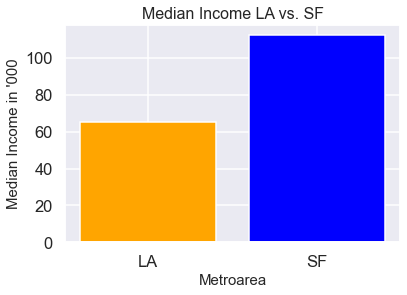

In [301]:
# Created a graph to compare median income between LA and SF
fig, ax = plt.subplots()

# Plot a bar-chart
ax.bar(cities, (la_median_inc, sf_median_inc), color = ('Orange', 'Blue'))

# Set title and lables
ax.set_ylabel("Median Income in '000", size = 15)
ax.set_xlabel ("Metroarea", size = 15)
ax.set_title('Median Income LA vs. SF', size = 16)

plt.show()

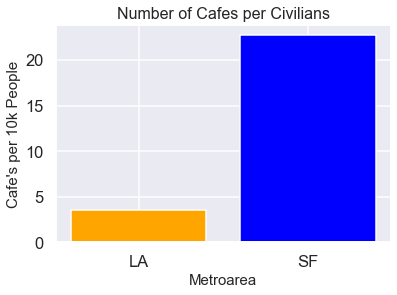

In [298]:
# Created a graph to show the number of Cafes per 10k people
fig, ax = plt.subplots()

# Plot a bar-chart
ax.bar(cities, (la_cafe_per_10kpop, sf_cafe_per_10kpop), color = ('Orange', 'Blue'))

# Set title and lables

ax.set_ylabel("Cafe's per 10k People", size = 15)
ax.set_xlabel ("Metroarea", size = 15)
ax.set_title('Number of Cafes per Civilians', size = 16)

plt.show()

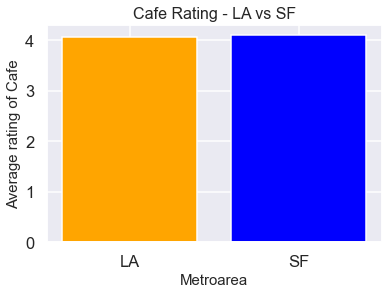

In [325]:
# Created a bar graph comparing average cafe restaurant rating between LA and SF
fig, ax = plt.subplots()

# Plot a bar-chart
ax.bar(cities, city_rating, color = ('Orange', 'Blue') )

# Set title and lables

# ax.set_xticklabels(['Los Angeles','San Francisco'], minor=False )
ax.set_ylabel("Average rating of Cafe", size = 15)
ax.set_xlabel ("Metroarea", size = 15)
ax.set_title('Cafe Rating - LA vs SF', size = 16)

plt.show()

# Cafes in SF and LA have very similar average ratings. Caf

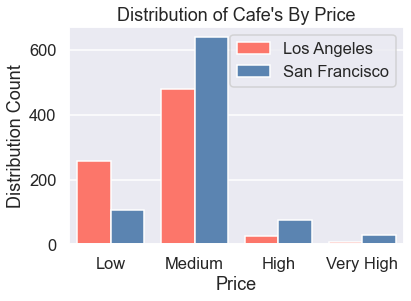

In [324]:
# Created a Grap

sns.set_style('darkgrid')
sns.set_context('talk')
sns.countplot(x = 'price_text', data = df, order = ['Low', 'Medium', 'High', 'Very High'], 
              hue = 'metro_area', palette = ['#FC766AFF', '#5B84B1FF'], saturation = 1)
plt.xlabel("Price")
plt.ylabel("Distribution Count")
plt.title("Distribution of Cafe's By Price") 
plt.legend().set_title('')

In [ ]:
# final recommendation. 